# Spaceship Titanic

Predict which passengers are transported to an alternate dimension.

# Setup

In [20]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ON_KAGGLE = os.getenv("KAGGLE_URL_BASE") is not None
DATA_DIR = "/kaggle/input/spaceship-titanic" if ON_KAGGLE else "data"

input_df = pd.read_csv(f"{DATA_DIR}/train.csv")
kaggle_df = pd.read_csv(f"{DATA_DIR}/test.csv")
all_df = [input_df, kaggle_df]

# EDA

In [21]:
input_df.info()
input_df.nunique()
input_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Continuous Features

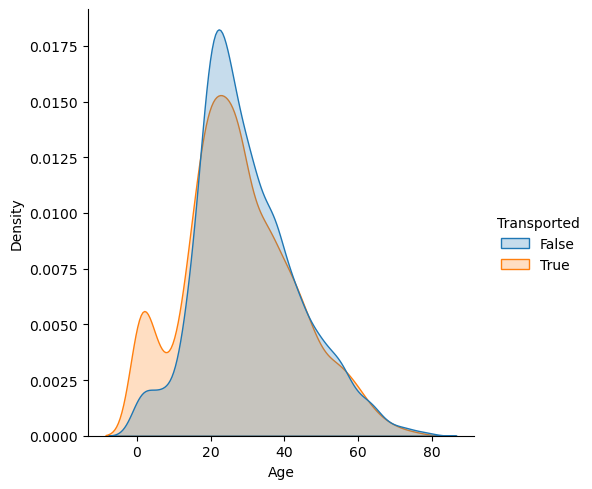

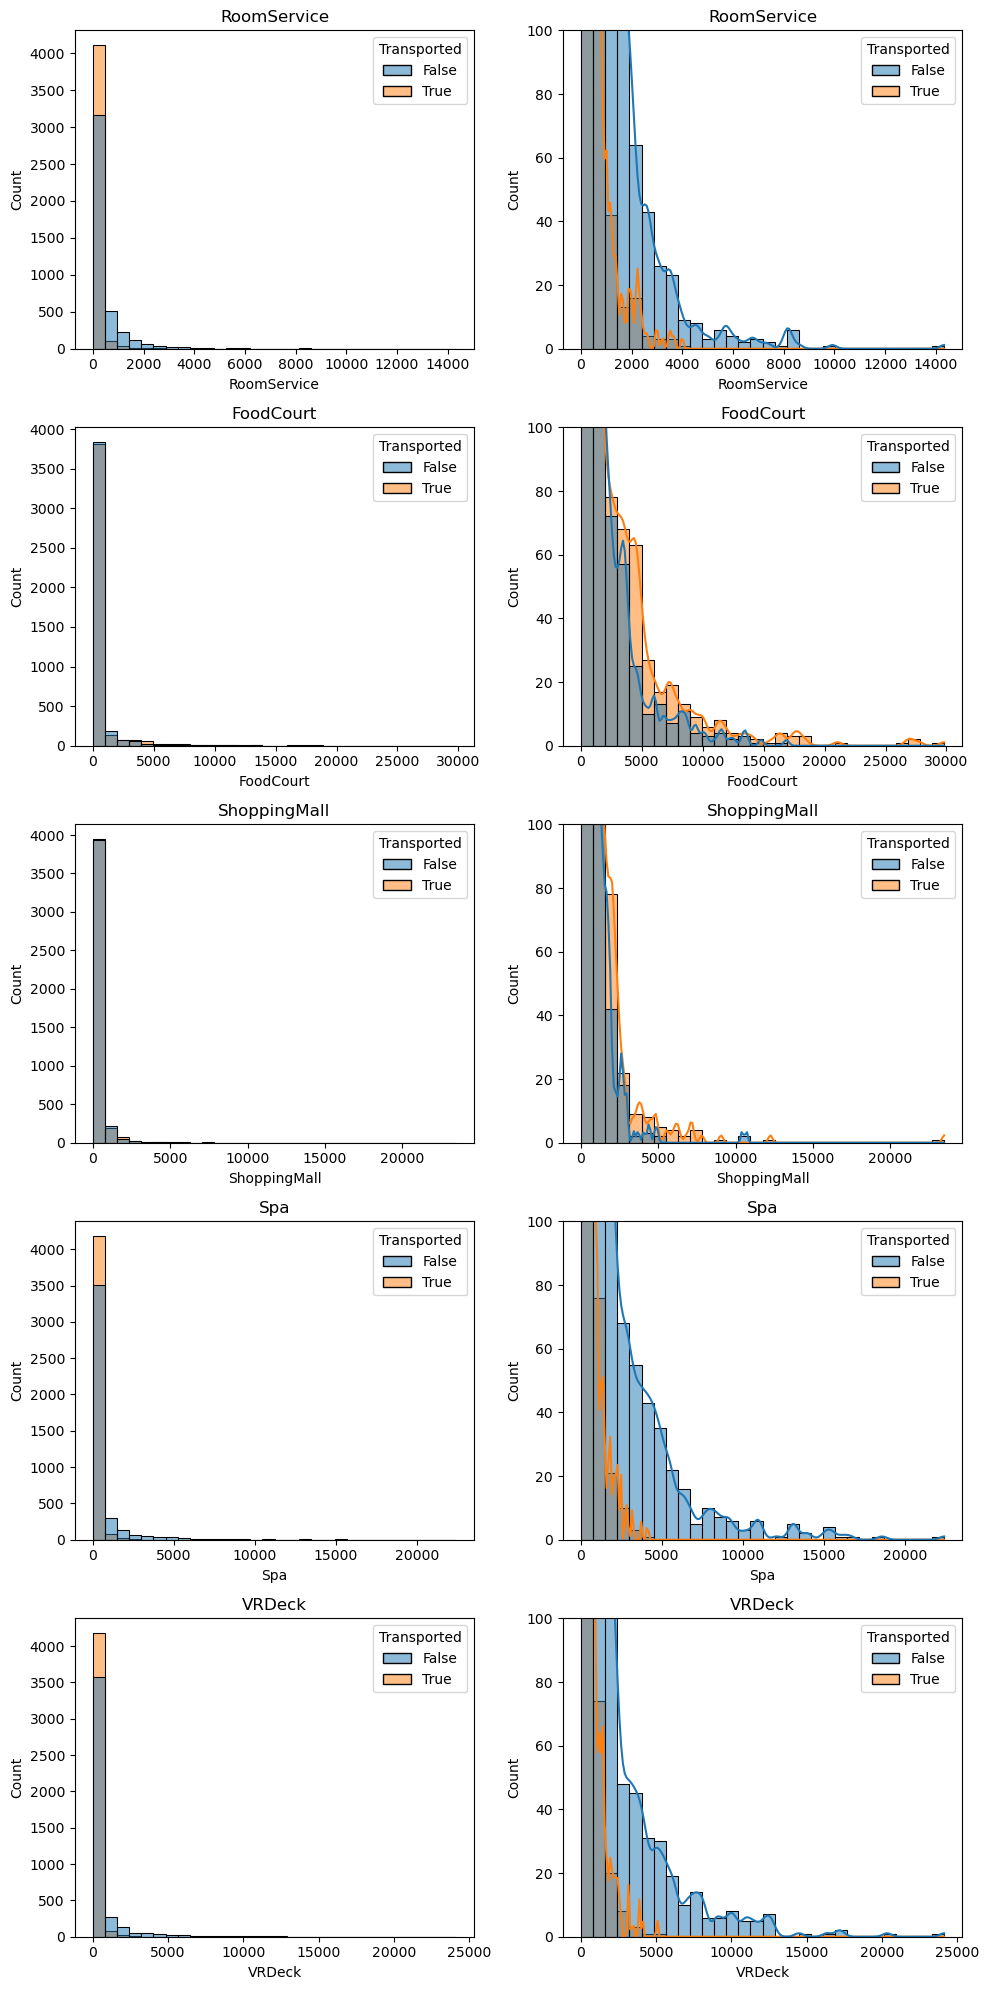

In [22]:
expenses_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Plot age distribution
sns.displot(input_df, x="Age", hue="Transported", kind="kde", fill=True)

# Plot expenses distribution
fig = plt.figure(figsize=(10, 20))
for i, expense in enumerate(expenses_features):
    # Left plot
    ax = fig.add_subplot(5, 2, 2 * i + 1)
    sns.histplot(
        data=input_df, x=expense, axes=ax, bins=30, kde=False, hue="Transported"
    )
    ax.set_title(expense)

    # Right plot (truncated)
    ax = fig.add_subplot(5, 2, 2 * i + 2)
    sns.histplot(
        data=input_df, x=expense, axes=ax, bins=30, kde=True, hue="Transported"
    )
    plt.ylim([0, 100])
    ax.set_title(expense)
fig.tight_layout()
plt.show()

### Categorical features

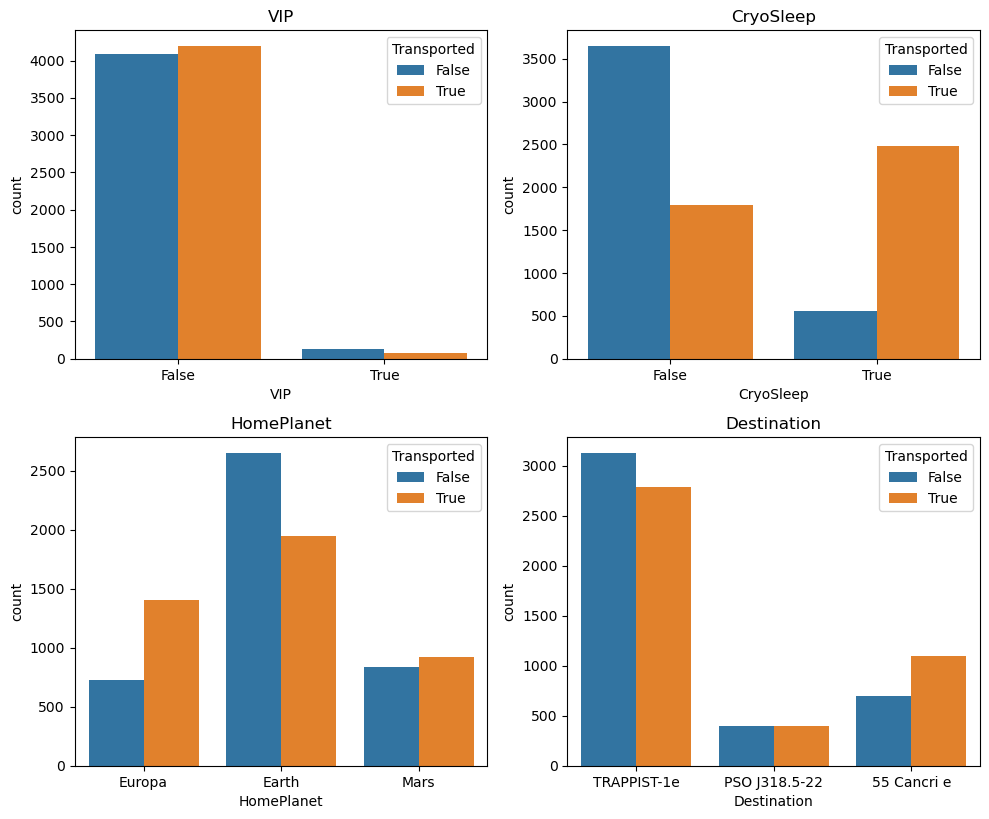

In [23]:
categorical_features = ["VIP", "CryoSleep", "HomePlanet", "Destination"]

fig = plt.figure(figsize=(10, 16))
for i, feature in enumerate(categorical_features):
    ax = fig.add_subplot(4, 2, i + 1)
    sns.countplot(data=input_df, x=feature, hue="Transported", axes=ax)
    ax.set_title(feature)
plt.tight_layout()
plt.show()

### Qualitative features

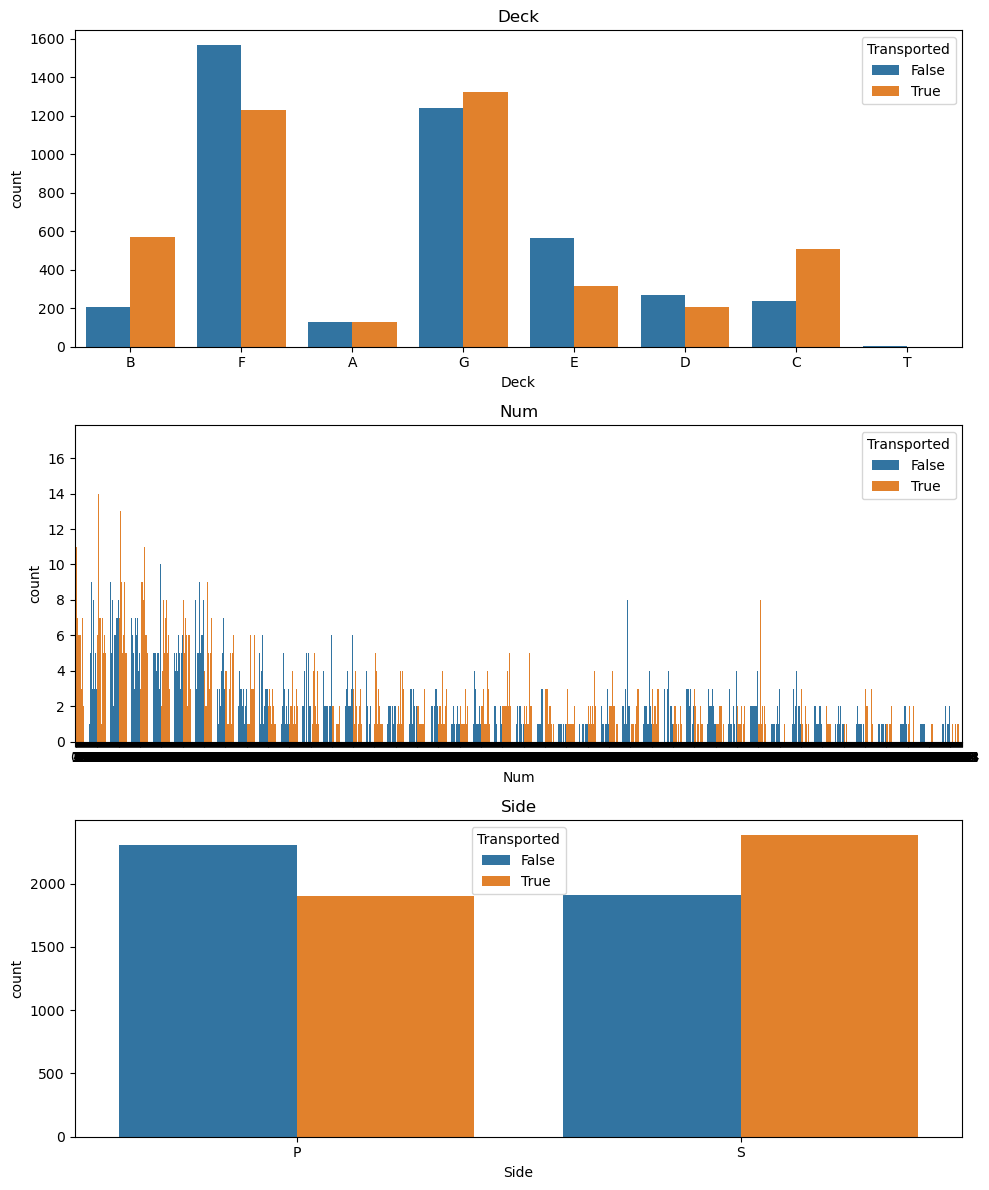

In [24]:
# Extract features from Cabin
new_cols = ["Deck", "Num", "Side"]
for df in all_df:
    df[new_cols] = df["Cabin"].str.split("/", expand=True)

# Plot
fig = plt.figure(figsize=(10, 12))
for i, feature in enumerate(new_cols):
    ax = fig.add_subplot(3, 1, i + 1)
    sns.countplot(data=input_df, x=feature, hue="Transported", ax=ax)
    ax.set_title(feature)

fig.tight_layout()
plt.show()

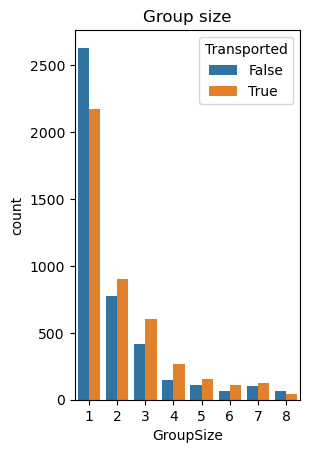

In [25]:
# Extract group from PassengerId
new_cols = ["Group", "GroupSize"]
for df in all_df:
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["GroupSize"] = df["Group"].map(df["Group"].value_counts())
    df["IsAlone"] = df["GroupSize"].apply(lambda x: 1 if x == 1 else 0)

plt.subplot(1, 2, 2)
sns.countplot(data=input_df, x="GroupSize", hue="Transported")
plt.title("Group size")
fig.tight_layout()

Text(0.5, 1.0, 'Family size')

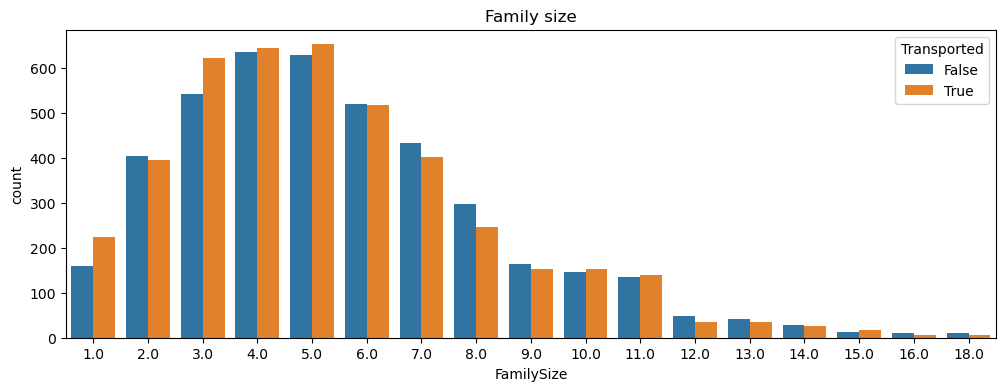

In [26]:
# Extract family name, and create Family & FamilySize features
for df in all_df:
    df["Family"] = df["Name"].str.split().str[-1]
    df["FamilySize"] = df["Family"].map(df["Family"].value_counts())

plt.figure(figsize=(12, 4))
sns.countplot(data=input_df, x="FamilySize", hue="Transported")
plt.title("Family size")

# Features Selection & Engineering

In [27]:
drop_features = ["VIP", "Name", "Cabin", "Family", "Group", "PassengerId"]
kaggle_ids = kaggle_df["PassengerId"]

# Drop bad features
for df in all_df:
    df.drop(drop_features, axis=1, inplace=True)

input_df.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,GroupSize,IsAlone,FamilySize
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P,1,1,1.0
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S,1,1,4.0
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,2,0,6.0
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,2,0,6.0
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S,1,1,6.0


In [28]:
from sklearn.preprocessing import OrdinalEncoder

# Convert object columns to category
for df in all_df:
    object_cols = df.select_dtypes(include="object").columns
    df[object_cols] = df[object_cols].astype("category")

# Encode categorical features
oc = OrdinalEncoder()
encode_df = pd.concat([input_df, kaggle_df])
category_cols = encode_df.select_dtypes(include="category").columns
encode_df[category_cols] = oc.fit_transform(encode_df[category_cols])

# Save new df
del input_df, kaggle_df
input_df = encode_df.iloc[:8693]
kaggle_df = encode_df.iloc[8693:]
all_df = [input_df, kaggle_df]
del encode_df

# Remove target from new test dataframe
kaggle_df.drop("Transported", axis=1, inplace=True)
input_df.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,GroupSize,IsAlone,FamilySize
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,False,1.0,0,0.0,1,1,1.0
1,0.0,0.0,2.0,24.0,109.0,9.0,25.0,549.0,44.0,True,5.0,0,1.0,1,1,4.0
2,1.0,0.0,2.0,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,0,1.0,2,0,6.0
3,1.0,0.0,2.0,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,0,1.0,2,0,6.0
4,0.0,0.0,2.0,16.0,303.0,70.0,151.0,565.0,2.0,True,5.0,1,1.0,1,1,6.0


In [29]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Replace missing values from expenses with 0 if df["CryoSleep"] is 1
for df in all_df:
    df.loc[df["CryoSleep"] == 1, expenses_features] = 0

null_cols = input_df.columns[input_df.isnull().any()].tolist()

# Impute missing values
imputer = SimpleImputer(strategy="median")
transformer = ColumnTransformer([("imputer", imputer, null_cols)])

for df in all_df:
    df[null_cols] = transformer.fit_transform(df[null_cols])

<Axes: xlabel='Age', ylabel='count'>

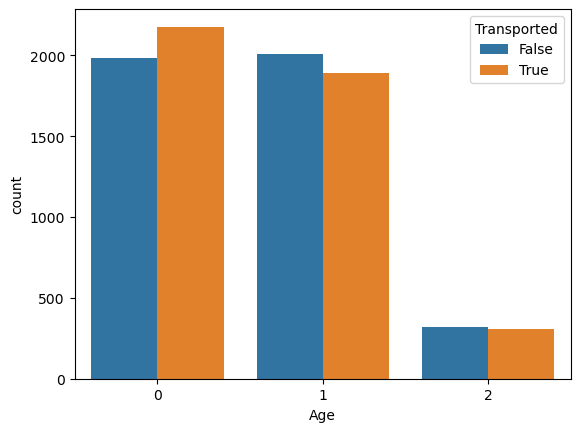

In [30]:
# Split age into bins
for df in all_df:
    df["Age"] = pd.cut(df["Age"], bins=3, labels=False)
    df["IsNewborn"] = df["Age"].apply(lambda x: 1 if x == 0 else 0)

sns.countplot(data=input_df, x="Age", hue="Transported")

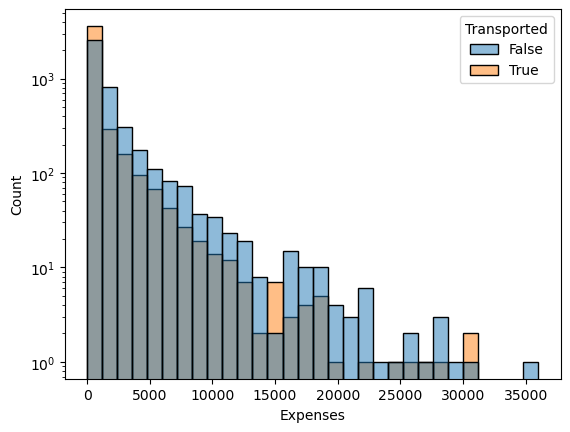

In [31]:
# Combine expenses
for df in all_df:
    df["Expenses"] = df[expenses_features].sum(axis=1)
    df["HasSpent"] = df["Expenses"].apply(lambda x: 1 if x > 0 else 0)

sns.histplot(data=input_df, x="Expenses", hue="Transported", bins=30)
plt.yscale("log")

# Train & Evaluate Model

In [32]:
from sklearn.model_selection import train_test_split

input_df["Transported"] = input_df["Transported"].astype("bool")

X_train, X_val, y_train, y_val = train_test_split(
    input_df.drop("Transported", axis=1),
    input_df["Transported"],
    test_size=0.2,
    random_state=69,
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
X_train.head()

(6954, 18) (1739, 18) (6954,) (1739,)


,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,GroupSize,IsAlone,FamilySize,IsNewborn,Expenses,HasSpent
8508,0.0,0.0,0.0,0,0.0,0.0,0.0,208.0,754.0,5.0,1858.0,0.0,8,0,11.0,1,962.0,1
7444,0.0,0.0,2.0,0,1.0,7.0,0.0,689.0,0.0,5.0,1648.0,0.0,1,1,7.0,1,697.0,1
1577,0.0,0.0,2.0,1,0.0,67.0,213.0,2.0,1442.0,6.0,269.0,0.0,2,0,9.0,0,1724.0,1
48,0.0,0.0,0.0,1,790.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1,1,2.0,0,790.0,1
1597,0.0,0.0,2.0,0,324.0,0.0,201.0,2.0,256.0,6.0,264.0,1.0,1,1,2.0,1,783.0,1


### XGBoost

In [33]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


param_grid = {
    "n_estimators": [10, 25, 50, 75, 100],
    "learning_rate": [0.2, 0.15, 0.1, 0.05],
    "eval_metric": ["mlogloss"],
}

grid = GridSearchCV(
    XGBClassifier(verbosity=0), param_grid=param_grid, cv=5, scoring="accuracy"
)
grid.fit(X_train, y_train)
best_params = grid.best_params_

print("Best score of cross validation: {:.2f}".format(grid.best_score_))
print("Best parameters:", best_params)

Best score of cross validation: 0.81
Best parameters: {'eval_metric': 'mlogloss', 'learning_rate': 0.15, 'n_estimators': 75}


In [34]:
xgb = XGBClassifier(verbosity=0)
xgb.set_params(**best_params)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [35]:
# Predict on kaggle_df
y_pred = xgb.predict(kaggle_df).astype(bool)

# Save predictions to csv
output = pd.DataFrame({"PassengerId": kaggle_ids, "Transported": y_pred})
output.to_csv("submission.csv", index=False)

output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
